### Test Script for DL Evaluation for Accelerometer (CNN-LSTM and BILSTM)

@ Author: Niloy Chakraborty

@ Author EMail: chakrabortyniloy2018@gmail.com


In [ ]:
# Connect to Google Drive. If using Jupyter, then comment this cell.
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/THESIS/

Mounted at /gdrive
/gdrive/MyDrive/THESIS


#### Load the libraries

In [ ]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
# import tensorflow_addons as tfa


In [ ]:
import os
import yaml

import tensorflow as tf

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import LSTM, Dropout,Dense,RepeatVector,TimeDistributed,Input,BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam as adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

In [ ]:
import tensorflow as tf
tf.version.VERSION

'2.6.0'

#### Load Test Data

In [ ]:
Category = "Acc_with_noise"

In [ ]:
filepath = 'Acc_25_secs_final_combined_faulty_data_test.csv'

In [ ]:
header = ['AccX','AccY','AccZ','GyrX','GyrY','GyrZ','Altitude','Cmd1','Cmd2','Cmd3','Cmd4','Roll','Pitch','Yaw','ThurstRefOut1','ThurstRefOut2','ThurstRefOut3','ThurstRefOut4','Label']

In [ ]:
df = pd.read_csv(filepath, header = None)
df = df.rename(columns=df.iloc[0]).drop(df.index[0])
df = df.iloc[:, 1:]
df["Label"] = pd.to_numeric(df["Label"])
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,AccX,AccY,AccZ,GyrX,GyrY,GyrZ,Altitude,Cmd1,Cmd2,Cmd3,Cmd4,Roll,Pitch,Yaw,ThurstRefOut1,ThurstRefOut2,ThurstRefOut3,ThurstRefOut4,Label
1,0.03380774,-0.11192460000000001,-9.492839,-0.0098925,-0.007933972,0.00108462,0.44,342.9332,-342.9577,342.8969,-342.9631,-1.965233e-06,-2.155978e-06,-5.859605e-07,-0.22403289999999998,-0.2240489,-0.22400920000000002,-0.22405239999999998,0
2,-0.116923,-0.2512355,-14.08014,-0.01084344,-0.009036063,-2.253169e-05,0.44,343.0175,-342.912,342.8928,-342.9287,-4.02452e-06,-4.6669999999999995e-06,-7.215308e-08,-0.224088,-0.224019,-0.2240065,-0.22403,0
3,0.22785189999999997,0.06732436,-13.62979,-0.008328836,-0.006301623,0.0025199379999999998,0.44,342.9608,-342.8717,343.0659,-342.8525,6.818334e-06,7.100436999999999e-06,5.960543e-07,-0.2240509,-0.2239928,-0.2241196,-0.22398020000000002,0
4,-0.01241245,-0.1545401,-13.94356,-0.01056849,-0.008493732,0.0007364108,0.44,342.8445,-343.066,342.7531,-343.0873,-3.975494e-06,-3.691068e-06,1.940148e-06,-0.223975,-0.2241197,-0.22391529999999998,-0.22413360000000002,0
5,0.21535289999999999,0.05578018,-13.64611,-0.008419157,-0.006429253,0.00240215,0.44,343.4182,-342.416,343.5187,-342.3979,1.696333e-05,1.88649e-05,1.3310810000000002e-05,-0.22434980000000002,-0.2236951,-0.2244154,-0.2236833,0


In [ ]:
# df = df[df["Label"] != 3]

In [ ]:
df["Label"].unique()

array([0, 1, 2, 3, 4])

In [ ]:
df = df.apply(pd.to_numeric)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 462500 entries, 1 to 462500
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   AccX           462500 non-null  float64
 1   AccY           462500 non-null  float64
 2   AccZ           462500 non-null  float64
 3   GyrX           462500 non-null  float64
 4   GyrY           462500 non-null  float64
 5   GyrZ           462500 non-null  float64
 6   Altitude       462500 non-null  float64
 7   Cmd1           462500 non-null  float64
 8   Cmd2           462500 non-null  float64
 9   Cmd3           462500 non-null  float64
 10  Cmd4           462500 non-null  float64
 11  Roll           462500 non-null  float64
 12  Pitch          462500 non-null  float64
 13  Yaw            462500 non-null  float64
 14  ThurstRefOut1  462500 non-null  float64
 15  ThurstRefOut2  462500 non-null  float64
 16  ThurstRefOut3  462500 non-null  float64
 17  ThurstRefOut4  462500 non-nul

In [ ]:
df["Label"].unique()

array([0, 1, 2, 3, 4])

In [ ]:
new_cols = ["AccX","AccY","AccZ","GyrX","GyrY","GyrZ","Cmd1","Cmd3","Roll","Pitch","Yaw","Label"]

In [ ]:
df = df[new_cols]

In [ ]:
df.shape

(462500, 12)

In [ ]:
df["Label"].value_counts()

0    280443
1     47150
4     46445
3     46156
2     42306
Name: Label, dtype: int64

In [ ]:
df["Label"].unique()

array([0, 1, 2, 3, 4])

### Data Pre-processing

In [ ]:
y = df["Label"]
X = df.drop("Label",axis= 1)

In [ ]:
# Scaling
from sklearn.preprocessing import RobustScaler
new_cols = ["AccX","AccY","AccZ","GyrX","GyrY","GyrZ","Cmd1","Cmd3","Roll","Pitch","Yaw"]

scale_columns = new_cols

scaler = RobustScaler()

scaler = scaler.fit(X[scale_columns])

X.loc[:, scale_columns] = scaler.transform(X[scale_columns].to_numpy())


In [ ]:
n_features = len(new_cols)

In [ ]:
# Windowing
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 64
STEP = 40

X_test, y_test = create_dataset(
    X[new_cols], 
    y, 
    TIME_STEPS, 
    STEP
)

In [ ]:
X_test.shape

(11561, 64, 11)

In [ ]:
# Data Reshaping
X_test = X_test.reshape(X_test.shape[0],4,int(TIME_STEPS/4),n_features)

In [ ]:
print(X_test.shape, y_test.shape)


(11561, 4, 16, 11) (11561, 1)


In [ ]:
unique, counts = np.unique(y_test, return_counts=True)

print(np.asarray((unique, counts)).T)

[[   0 7044]
 [   1 1171]
 [   2 1047]
 [   3 1146]
 [   4 1153]]


In [ ]:
# Label Encoding
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_test)

y_test = enc.transform(y_test)
# y_test = enc.transform(y_test)

In [ ]:
print(X_test.shape, y_test.shape)


(11561, 4, 16, 11) (11561, 5)


### Load the Model (CNN-LSTM SHOWN)

In [ ]:
model = load_model('Acc_Models/Acc_CNN_LSTM_5_Class_64_28-07-2021.h5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 4, 13, 32)         1440      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 4, 10, 32)         4128      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 4, 10, 32)         0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 4, 320)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 150)               282600    
_________________________________________________________________
dropout_9 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)               

#### Evaluate Test performance

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("Metrics are: ", results)

Evaluate on test data
362/362 [==============================] - 16s 2ms/step - loss: 0.0242 - accuracy: 0.9922
Metrics are:  [0.024239560589194298, 0.9922152161598206]


In [ ]:
len(X_test)

11561

In [ ]:
  y_pred = model.predict(X_test,batch_size=11561)


In [ ]:
y_pred

array([[9.9965048e-01, 1.6654429e-06, 8.8081879e-07, 3.4692098e-04,
        1.6630168e-09],
       [8.0509774e-02, 3.2898304e-05, 1.2255181e-03, 9.1823184e-01,
        5.0811057e-08],
       [9.9992108e-01, 3.2457632e-07, 3.0211442e-08, 7.8471079e-05,
        8.8101013e-11],
       ...,
       [2.5489995e-01, 8.5165276e-04, 7.4415755e-01, 9.0897207e-05,
        8.4403916e-12],
       [9.8078316e-01, 1.2658568e-03, 1.7934227e-02, 1.6689368e-05,
        2.1047438e-11],
       [8.6371219e-01, 1.5823189e-03, 1.3423324e-01, 4.7217676e-04,
        4.8705739e-10]], dtype=float32)

In [ ]:
y_test = enc.inverse_transform(y_test)
y_pred = enc.inverse_transform(y_pred)


In [ ]:
y_pred


array([[0],
       [3],
       [0],
       ...,
       [2],
       [0],
       [0]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7044
           1       1.00      1.00      1.00      1171
           2       1.00      1.00      1.00      1047
           3       0.93      1.00      0.96      1146
           4       1.00      1.00      1.00      1153

    accuracy                           0.99     11561
   macro avg       0.99      1.00      0.99     11561
weighted avg       0.99      0.99      0.99     11561



In [ ]:
cf_matrix= confusion_matrix(y_test, y_pred)

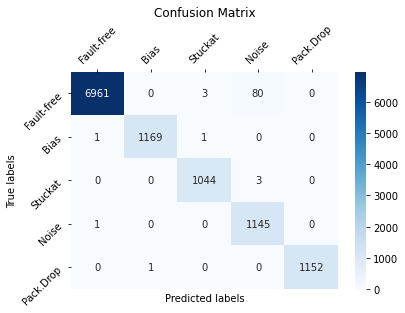

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax,cmap="Blues");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Fault-free', 'Bias','Stuckat','Noise','Pack.Drop'],rotation=45); 
ax.yaxis.set_ticklabels(['Fault-free', 'Bias','Stuckat','Noise','Pack.Drop'],rotation=45);
ax.xaxis.tick_top()
